   ## Project

## Object Detection with Faster R-CNN

Faster R-CNN is a method for object detection that uses region proposal. In this prject we build the model that detect several objects by name and to use the likelihood of the object prediction being correct.

##  Objective

Apply Object detection with Faster R-CNN to classify predetermined objects using objects name and/or to use the likelihood of the object.

<ul>
    <li>Object detection with Faster R-CNN </li>
        <ul>
            <li>Import Libraries and Define Auxiliary Functions  </li>
            <li>Load Pre-trained Faster R-CNN </li>
            <li>Object Localization </li>
            <li>Object Detection  </li>
            <li>Test Model With An Uploaded Image </li>
     
  
    
</ul>


In [1]:
#import libraries

import torchvision
from torchvision import  transforms 
import torch
from torch import no_grad
#libraries for getting data from the web
import requests
# libraries for image processing and visualization
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


## Load Pre-trained Faster R-CNN

Faster R-CNN is a model that predicts both bounding boxes and class scores for potential objects in the image pre-trained on COCO.
    

In [2]:
model_ = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model_.eval()

for name, param in model_.named_parameters():
    param.requires_grad = False
print("done")

/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /home/jupyterlab/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

done


In [3]:
def model(x):
    with torch.no_grad():
        yhat = model_(x)
    return yhat


This function will assign a string name to a predicted class and eliminate predictions whose likelihood is under a threshold.

In [4]:
def get_predictions(pred,threshold=0.8,objects=None ):

    predicted_classes= [(COCO_INSTANCE_CATEGORY_NAMES[i],p,[(box[0], box[1]), (box[2], box[3])]) for i,p,box in zip(list(pred[0]['labels'].numpy()),pred[0]['scores'].detach().numpy(),list(pred[0]['boxes'].detach().numpy()))]
    predicted_classes=[  stuff  for stuff in predicted_classes  if stuff[1]>threshold ]
    
    if objects  and predicted_classes :
        predicted_classes=[ (name, p, box) for name, p, box in predicted_classes if name in  objects ]
    return predicted_classes

Draws box around each object

In [5]:
def draw_box(predicted_classes,image,rect_th= 10,text_size= 3,text_th=3):

    img=(np.clip(cv2.cvtColor(np.clip(image.numpy().transpose((1, 2, 0)),0,1), cv2.COLOR_RGB2BGR),0,1)*255).astype(np.uint8).copy()
    for predicted_class in predicted_classes:
   
        label=predicted_class[0]
        probability=predicted_class[1]
        box=predicted_class[2]

        cv2.rectangle(img, box[0], box[1],(0, 255, 0), rect_th) # Draw Rectangle with the coordinates
        cv2.putText(img,label, box[0],  cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th) 
        cv2.putText(img,label+": "+str(round(probability,2)), box[0],  cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    del(img)
    del(image)

this function will free up some memory

In [6]:
def save_RAM(image_=False):
    global image, img, pred
    torch.cuda.empty_cache()
    del(img)
    del(pred)
    if image_:
        image.close()
        del(image)

Here are the 91 classes

In [7]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]
len(COCO_INSTANCE_CATEGORY_NAMES)

91

## Object Localization

Object Localization we locate the presence of objects in an image and indicate the location with a bounding box.

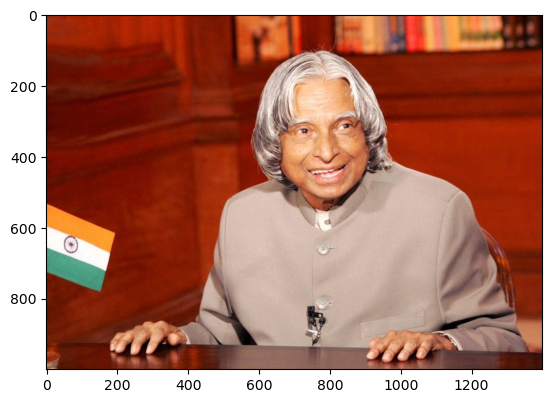

In [8]:
img_path='obj3.jpg'
half = 0.5
image = Image.open(img_path)

image.resize( [int(half * s) for s in image.size] )

plt.imshow(image)
plt.show()

In [9]:
#transform image to tensor
transform = transforms.Compose([transforms.ToTensor()])

In [10]:
img = transform(image)

In [11]:
#predict 
pred = model([img])

we have the 21 different class predictions, ordered by likelihood scores for potential objects.


In [12]:
pred[0]['labels']


tensor([ 1, 67, 85, 67, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 67, 84,
        67, 84, 67, 84, 84, 84, 62, 63, 62, 84, 84, 47])

In [13]:
pred[0]['scores']

tensor([0.9987, 0.7734, 0.7069, 0.5890, 0.4224, 0.3747, 0.3576, 0.3304, 0.2843,
        0.2762, 0.1912, 0.1815, 0.1757, 0.1737, 0.1584, 0.1408, 0.1398, 0.1212,
        0.1131, 0.1118, 0.1071, 0.1067, 0.0959, 0.0925, 0.0722, 0.0690, 0.0655,
        0.0585, 0.0522, 0.0511])

In [14]:
#The class number corresponds to the index of the list with the corresponding category name
index=pred[0]['labels'][0].item()
COCO_INSTANCE_CATEGORY_NAMES[index]

'person'

In [15]:
bounding_box=pred[0]['boxes'][0].tolist()
bounding_box

[312.3788757324219, 108.32099914550781, 1320.0416259765625, 968.6285400390625]

In [16]:
#round the rectangle
t,l,r,b=[round(x) for x in bounding_box]

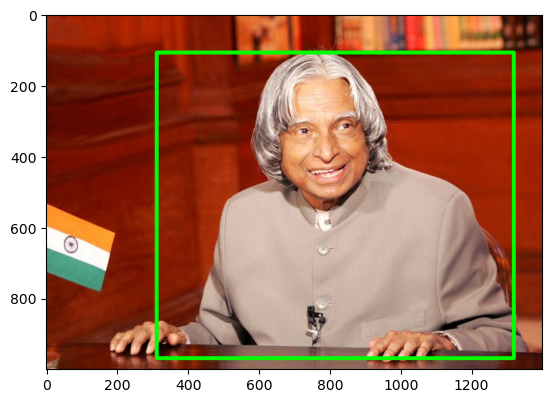

In [17]:
#We convert the tensor to an open CV array and plot an image with the box
img_plot=(np.clip(cv2.cvtColor(np.clip(img.numpy().transpose((1, 2, 0)),0,1), cv2.COLOR_RGB2BGR),0,1)*255).astype(np.uint8)
cv2.rectangle(img_plot,(t,l),(r,b),(0, 255, 0), 10) # Draw Rectangle with the coordinates
plt.imshow(cv2.cvtColor(img_plot, cv2.COLOR_BGR2RGB))
plt.show()

del img_plot, t, l, r, b


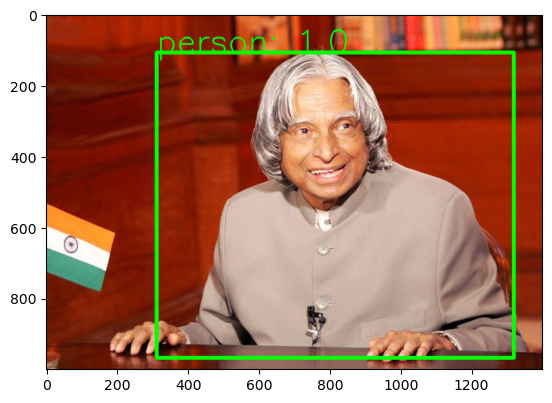

In [18]:
pred_class=get_predictions(pred,objects="person")
draw_box(pred_class, img)

del pred_class

We can locate multiple objects

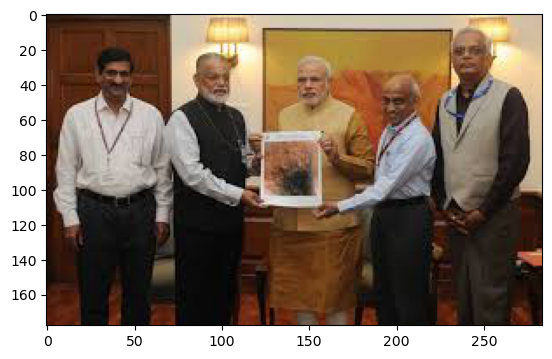

In [19]:
img_path='obj4.jfif'
image = Image.open(img_path)
image.resize([int(half * s) for s in image.size])
plt.imshow(np.array(image))
plt.show()


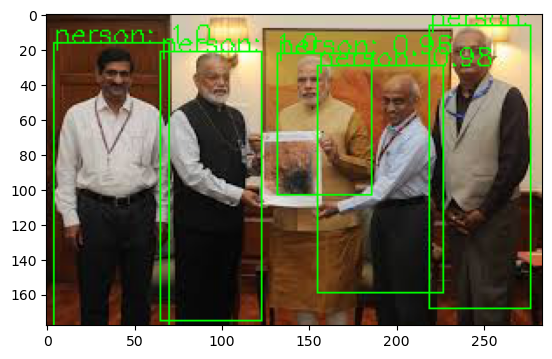

In [20]:
# we can set the threshold
img = transform(image)
pred = model([img])
pred_thresh=get_predictions(pred,threshold=0.8,)
draw_box(pred_thresh,img,rect_th= 1,text_size= 0.5,text_th=1)
del pred_thresh